# MOSAIKS Hands-on Session: Modeling Maize Yield

This notebook demonstrates the application of Multi-task Observation using Satellite Imagery & Kitchen Sinks (MOSAIKS), a machine learning approach utilizing satellite imagery, to model maize yield in Togo. We analyze the relationship between MOSAIKS-derived satellite features and observed maize yield from 2016 to 2019. The trained model is then used to predict maize yield up to 2023, showcasing the potential of MOSAIKS for agricultural monitoring in the face of limited data collection.



## Methodology
This analysis employs a supervised machine learning approach to predict maize yield using satellite imagery features. The workflow consists of the following key steps:

1. **Data Acquisition:** Obtain historical maize yield data for Togo from FEWS NET and pre-processed satellite imagery features derived using the MOSAIKS framework. The satellite features were computed at about 1 km resolution and then summarized to the second level of adminstreative division (Prefecture).
2. **Data Preprocessing:** Merge yield data with satellite features based on spatial and temporal attributes. Prepare the data for model training by creating dummy variables for location fixed effects and splitting the dataset into training and testing sets.
3. **Model Training:** Train a Ridge Regression model using the training data to learn the relationship between satellite features and maize yield. Optimize model performance through hyperparameter tuning using cross-validation.
4. **Model Evaluation:** Assess the predictive accuracy of the trained model on the testing dataset using the R-squared metric.
5. **Yield Prediction:** Apply the trained model to predict maize yield across Togo for the years 2016 to 2023, including years beyond the training data.
6. **Visualization:** Create maps to visualize the observed and predicted maize yield spatially and temporally, providing insights into yield patterns and trends.

## Setup

This notebook utilizes several key Python libraries:

* **Data Handling and Analysis:**  `pandas` and `numpy` provide fundamental data structures and functions for manipulating and analyzing data. `geopandas` extends these capabilities to work with geospatial data.
* **Visualization:** `matplotlib.pyplot` and `seaborn` enable the creation of static and interactive visualizations, aiding in data exploration and result presentation.
* **Machine Learning:** `sklearn` offers a comprehensive suite of tools for building and evaluating machine learning models, including algorithms like Ridge Regression and methods for data preprocessing.

In [1]:
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.5 MB/s eta 0:00:00


In [3]:
!wget https://zenodo.org/records/14270974/files/crop_data.zip?download=1 -O crop_data.zip
!unzip crop_data.zip

--2024-12-03 23:14:40--  https://zenodo.org/records/14270974/files/crop_data.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43876160 (42M) [application/octet-stream]
Saving to: ‘crop_data.zip’

crop_data.zip       100%[===================>]  41.84M  20.1MB/s    in 2.1s    

2024-12-03 23:14:43 (20.1 MB/s) - ‘crop_data.zip’ saved [43876160/43876160]

Archive:  crop_data.zip
  inflating: crop_data/fews_net_yield_TGO.csv  
  inflating: crop_data/gadm41_TGO_2.geojson  
  inflating: crop_data/feature_summary.csv  


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from google.colab import drive
from sklearn.linear_model import RidgeCV
from sklearn.calibration import IsotonicRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

## Mounting Google Drive

Mounting Google Drive in Colab essentially connects your Google Drive storage to the Colab environment. This allows you to access files and folders stored in your Drive directly within your Colab notebook. Think of it as creating a shortcut to your Drive within Colab.

**Why is this necessary?**

Colab notebooks run on temporary virtual machines. Mounting your Drive ensures that you can load and save data to your personal storage, persisting even after the Colab session ends. It also enables seamless access to larger datasets stored in your Drive, which would be impractical to upload directly to Colab.

After mounting Google Drive, we then define the path to the project folder on Google Drive. This directory contains the data files needed for the analysis.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_directory = os.path.join(
    "/",
    "content",
    "drive",
    "Shareddrives",
    "MOSAIKS Workshop",
    "Data",
)
drive_directory

'/content/drive/Shareddrives/MOSAIKS Workshop/Data'

## Create a local directory

This section creates a local directory within the Colab environment to store the project data. Data files are copied from the Google Drive directory to this local folder.

**Why use a local directory?**  

Accessing data locally on the Colab virtual machine (VM) significantly improves processing speed compared to reading directly from Google Drive. While copying the data initially takes a bit of time, this is outweighed by the performance gains during analysis.

In [ ]:
local_dir = "/content/data/"

os.makedirs(local_dir, exist_ok=True)

files_to_copy = os.path.join(drive_directory, "crop_data")

shutil.copytree(files_to_copy, local_dir, dirs_exist_ok=True)

'/content/data/'

Here we take a look at the contents of the local drive to ensure we have the necessary files copied.

In [ ]:
!ls -lh /content/data

total 92M
-r-------- 1 root root  92M Nov 10 19:55 feature_summary.csv
-r-------- 1 root root  72K Nov 11 00:50 fews_net_yield_TGO.csv
-r-------- 1 root root 123K Nov 10 19:21 gadm41_TGO_2.geojson


## Load Administrative Boundaries of Togo

This section focuses on loading the administrative boundaries of Togo, which define the spatial units for our analysis. We utilize a GeoJSON file containing the boundaries of Togo's administrative regions.


In [ ]:
TGO_boundaries = gpd.read_file(os.path.join(local_dir, "gadm41_TGO_2.geojson"))
TGO_boundaries.head()

,country,admin_1,admin_2,geometry
0,Togo,Centre,Blitta,"MULTIPOLYGON (((0.6222 7.9015, 0.6227 7.9017, ..."
1,Togo,Centre,Mô,"MULTIPOLYGON (((0.6173 8.5135, 0.6118 8.5127, ..."
2,Togo,Centre,Sotouboua,"MULTIPOLYGON (((0.9443 8.3788, 0.9321 8.3845, ..."
3,Togo,Centre,Tchamba,"MULTIPOLYGON (((1.2352 8.396, 1.2354 8.414, 1...."
4,Togo,Centre,Tchaudjo,"MULTIPOLYGON (((1.2391 8.6754, 1.2335 8.6737, ..."


In [ ]:
TGO_boundaries.explore()

## Load and Preprocess Crop Yield Data

This section focuses on loading and preparing the maize yield data for analysis. The data, sourced from [FEWS NET](https://fews.net/), represents historical maize yield estimates at the second administrative level in Togo. We perform the following steps:

1. **Data Loading:** Read the yield data from a CSV file (`fews_net_yield_TGO.csv`).
2. **Log Transformation:** Apply a logarithmic transformation to the yield values using `np.log1p()` to stabilize variance and improve model performance. This addresses potential skewness in the yield distribution.
3. **Maize Selection:** Filter the data to include only maize yield, excluding other crops.
4. **Spatial Join:** Merge the yield data with the administrative boundaries of Togo to create a geospatial dataset. This allows for spatial analysis and visualization.



In [ ]:
crop_data = pd.read_csv(os.path.join(local_dir, "fews_net_yield_TGO.csv"))
crop_data.loc[:, "log_yield"] = np.log1p(crop_data["yield"])
crop_data = crop_data.loc[crop_data['product'] == 'Maize (Corn)']
# crop_data = crop_data.loc[crop_data['product'] == 'Beans (mixed)']
crop_data

,country,admin_1,admin_2,year,season_name,season_type,product,area_planted,quantity_produced,yield,log_yield
4,Togo,Centre,Blitta,2016,Main,Harvest,Maize (Corn),13452.00,19326.11,1.436672,0.890633
12,Togo,Centre,Blitta,2017,Main,Harvest,Maize (Corn),19710.73,29701.12,1.506850,0.919027
20,Togo,Centre,Blitta,2018,Main,Harvest,Maize (Corn),19317.67,28474.24,1.474000,0.905836
29,Togo,Centre,Blitta,2019,Main,Harvest,Maize (Corn),19799.00,29436.00,1.486742,0.910973
38,Togo,Centre,Mô,2016,Main,Harvest,Maize (Corn),10809.00,16458.90,1.522703,0.925331
...,...,...,...,...,...,...,...,...,...,...,...
861,Togo,Plateaux,Ogou,2017,Main,Harvest,Maize (Corn),60426.00,85200.00,1.409989,0.879622
869,Togo,Plateaux,Ogou,2018,Main,Harvest,Maize (Corn),62304.00,93370.00,1.498620,0.915738
877,Togo,Plateaux,Wawa,2016,Main,Harvest,Maize (Corn),6708.00,9082.00,1.353906,0.856076
883,Togo,Plateaux,Wawa,2017,Main,Harvest,Maize (Corn),11704.00,15023.00,1.283578,0.825744


<ipython-input-13-a07fefa83b0c>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)


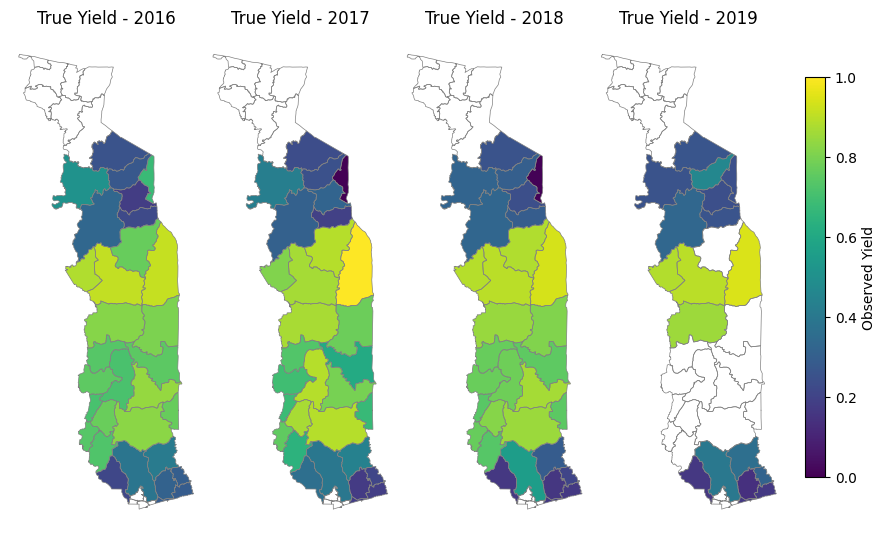

In [ ]:
crop_data_gdf = crop_data.merge(TGO_boundaries, on=["country", "admin_1", "admin_2"])
crop_data_gdf = gpd.GeoDataFrame(crop_data_gdf)

years = sorted(crop_data_gdf['year'].unique())

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 4, figure=fig, wspace=0.01, hspace=0.01)

vmin = crop_data_gdf['log_yield'].min()
vmax = crop_data_gdf['log_yield'].max()

for i, year in enumerate(years):
    ax = fig.add_subplot(gs[i])
    TGO_boundaries.boundary.plot(ax=ax, color='grey', lw=0.5)
    im = crop_data_gdf[crop_data_gdf['year'] == year].plot(
        column='log_yield',
        ax=ax,
        legend=False,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f'True Yield - {year}')
    ax.set_axis_off()

cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
fig.colorbar(im.collections[0], cax=cax, label='Observed Yield')

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
plt.show()

## Load and Prepare Satellite Imagery Features

This section focuses on loading and preparing the satellite imagery features that will be used to predict maize yield. These features, derived using the MOSAIKS framework, capture relevant information from high-resolution PlanetScope imagery. They are summarized statistics of Random Convolutional Features (RCFs) calculated for each administrative region (Prefecture) in Togo.

**Data Loading and Formatting:**

1. **Feature Loading:** The features are read from a CSV file (`feature_summary.csv`) into a pandas DataFrame. For each quarter of the year, 4000 RCFs are computed, resulting in a total of 16000 feature columns for each year/prefecture combination. These features are named using the pattern "planet_0_q1," where "0" represents the feature number (0-3999) and "q1" indicates the first quarter. This pattern continues for all four quarters (q1, q2, q3, q4).
2. **Spatial Integration:** The DataFrame is transformed into a GeoDataFrame using `geopandas`, enabling spatial operations and analysis. The administrative boundaries of Togo are merged with the feature data to provide geographic context.

**Visualizing Quarterly Features:**

To understand the temporal variation in satellite features, we pick one feature and plot it for each quarter. This visualization helps us observe how these features change throughout the year, providing insights into potential seasonal patterns and their relationship with maize yield.

This integration of satellite-derived features with spatial information is crucial for building a spatially-aware predictive model. It allows us to visualize the features geographically and link them to the maize yield data for model training.


In [ ]:
features = pd.read_csv(os.path.join(local_dir, "feature_summary.csv"))
features.head()

,country,admin_1,admin_2,year,planet_0_q1,planet_0_q2,planet_0_q3,planet_0_q4,planet_1_q1,planet_1_q2,...,planet_997_q3,planet_997_q4,planet_998_q1,planet_998_q2,planet_998_q3,planet_998_q4,planet_999_q1,planet_999_q2,planet_999_q3,planet_999_q4
0,Togo,Centre,Blitta,2016,0.034059,0.028130,0.007090,0.039566,0.032327,0.018890,...,0.104550,0.390826,0.086880,0.048972,0.062294,0.057653,0.603227,0.439633,0.094083,0.435992
1,Togo,Centre,Blitta,2017,0.091740,0.060450,0.073351,0.077535,0.052786,0.020566,...,0.279689,0.579065,0.168369,0.131208,0.040969,0.118672,0.320748,0.264108,0.591500,0.451850
2,Togo,Centre,Blitta,2018,0.099782,0.072666,0.109088,0.065963,0.038649,0.021820,...,0.457497,0.576939,0.206745,0.070264,0.071139,0.116523,0.353122,0.500156,0.571058,0.423053
3,Togo,Centre,Blitta,2019,0.065744,0.077545,0.116285,0.064548,0.033283,0.024243,...,0.498492,0.565818,0.167556,0.097914,0.092977,0.110927,0.304760,0.507746,0.546144,0.434186
4,Togo,Centre,Blitta,2020,0.054686,0.059825,0.066479,0.048202,0.018643,0.017654,...,0.359325,0.392158,0.112482,0.072326,0.056439,0.052037,0.288308,0.471186,0.490266,0.398532


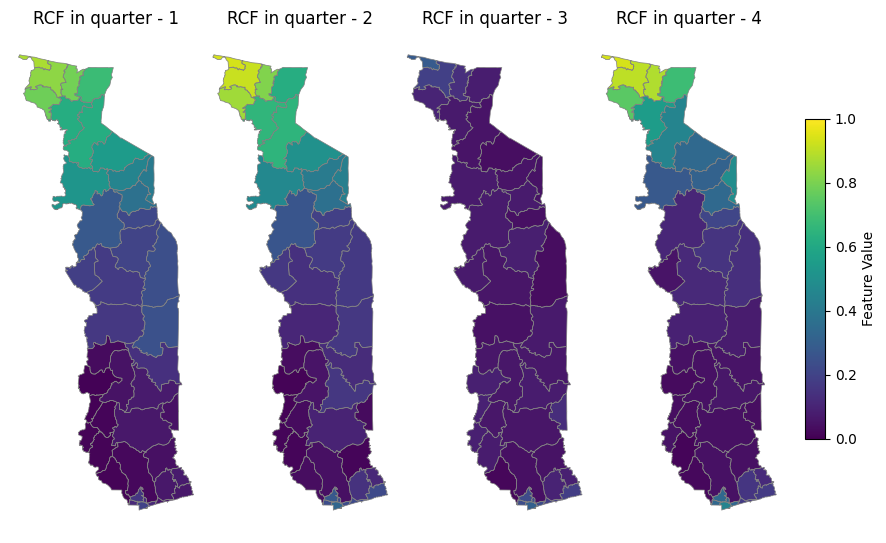

In [ ]:
features_gdf = features.merge(TGO_boundaries, on=["country", "admin_1", "admin_2"])
features_gdf = gpd.GeoDataFrame(features_gdf)

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 4, figure=fig, wspace=0.01, hspace=0.01)

vmin = np.min(
    [
        features_gdf['planet_0_q1'].min(),
        features_gdf['planet_0_q2'].min(),
        features_gdf['planet_0_q3'].min(),
        features_gdf['planet_0_q4'].min()
    ]
)
vmax = np.max(
    [
        features_gdf['planet_0_q1'].max(),
        features_gdf['planet_0_q2'].max(),
        features_gdf['planet_0_q3'].max(),
        features_gdf['planet_0_q4'].max()
    ]
)

for i, quart in enumerate(range(1, 5)):
    ax = fig.add_subplot(gs[i])
    TGO_boundaries.boundary.plot(ax=ax, color='grey', lw=0.5)
    im = features_gdf[features_gdf.year == 2017].plot(
        column=f'planet_10_q{quart}',
        ax=ax,
        legend=False,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f'RCF in quarter - {quart}')
    ax.set_axis_off()

cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
fig.colorbar(im.collections[0], cax=cax, label='Feature Value')

plt.show()

## Merge Yield Data with Satellite Features

This section describes the process of merging the maize yield data (labels) with the satellite imagery features. This crucial step creates a unified dataset that links yield observations with the corresponding spatial and temporal characteristics derived from satellite imagery.

**Data Merging:**

We perform a left join between the yield data (`crop_data`) and the satellite features (`features`) using their common index columns: `country`, `admin_1`, `admin_2`, and `year`. This ensures that all yield observations retain their associated features. The resulting DataFrame, named `joined`, combines the yield values with the satellite-derived features for each location and year.

This merged dataset is essential for training the predictive model. It enables the model to learn the relationships between satellite imagery features and maize yield, ultimately allowing us to predict yield based on these features.

In [ ]:
index_cols =  ["country", "admin_1", "admin_2", "year"]
joined = crop_data.set_index(index_cols).join(features.set_index(index_cols), how="left").reset_index()
joined = joined.dropna()
joined

,country,admin_1,admin_2,year,season_name,season_type,product,area_planted,quantity_produced,yield,...,planet_997_q3,planet_997_q4,planet_998_q1,planet_998_q2,planet_998_q3,planet_998_q4,planet_999_q1,planet_999_q2,planet_999_q3,planet_999_q4
0,Togo,Centre,Blitta,2016,Main,Harvest,Maize (Corn),13452.00,19326.11,1.436672,...,0.104550,0.390826,0.086880,0.048972,0.062294,0.057653,0.603227,0.439633,0.094083,0.435992
1,Togo,Centre,Blitta,2017,Main,Harvest,Maize (Corn),19710.73,29701.12,1.506850,...,0.279689,0.579065,0.168369,0.131208,0.040969,0.118672,0.320748,0.264108,0.591500,0.451850
2,Togo,Centre,Blitta,2018,Main,Harvest,Maize (Corn),19317.67,28474.24,1.474000,...,0.457497,0.576939,0.206745,0.070264,0.071139,0.116523,0.353122,0.500156,0.571058,0.423053
3,Togo,Centre,Blitta,2019,Main,Harvest,Maize (Corn),19799.00,29436.00,1.486742,...,0.498492,0.565818,0.167556,0.097914,0.092977,0.110927,0.304760,0.507746,0.546144,0.434186
4,Togo,Centre,Mô,2016,Main,Harvest,Maize (Corn),10809.00,16458.90,1.522703,...,0.171505,0.314562,0.052341,0.061343,0.057134,0.048252,0.531856,0.240437,0.216550,0.420496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Togo,Plateaux,Ogou,2017,Main,Harvest,Maize (Corn),60426.00,85200.00,1.409989,...,0.434438,0.496813,0.106089,0.181195,0.070168,0.082313,0.160076,0.319193,0.575615,0.460409
103,Togo,Plateaux,Ogou,2018,Main,Harvest,Maize (Corn),62304.00,93370.00,1.498620,...,0.492975,0.512830,0.226117,0.061909,0.094815,0.098014,0.290691,0.358159,0.464818,0.399949
104,Togo,Plateaux,Wawa,2016,Main,Harvest,Maize (Corn),6708.00,9082.00,1.353906,...,0.303165,0.143140,0.008514,0.038620,0.257094,0.007098,0.489355,0.376217,0.106153,0.528318
105,Togo,Plateaux,Wawa,2017,Main,Harvest,Maize (Corn),11704.00,15023.00,1.283578,...,0.446287,0.388279,0.008086,0.010498,0.073392,0.043275,0.387659,0.332374,0.633140,0.495504


## Model Training and Evaluation

This section outlines the process of training a machine learning model to predict the maize yield in a given area based on the satellite imagery features, and evaluating its performance.

**1. Data Preparation:**

* The joined dataset is split into features (X) and the target variable (y).
    * `X` contains the satellite imagery features, specifically the columns with names starting with 'planet_'. We also use spatial fixed effects (location dummy variables) to get more accurate location specific predictions.
    * `y` contains the maize yield values, which can either be levels (untransformed) or logs (log transofrmed).
* The data is further split into training and testing sets using `train_test_split` to evaluate the model's performance on unseen data.


In [ ]:
joined = pd.get_dummies(joined, columns=['admin_2'], prefix='admin_2')
# joined

In [ ]:
location_cols = joined.columns[joined.columns.str.startswith("admin_2_")].tolist()

feature_cols = joined.columns[joined.columns.str.startswith("planet_")].tolist()

X = joined[feature_cols + location_cols]
# y = joined["yield"]
y = joined["log_yield"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**2. Model Selection and Training:**

* A Ridge Regression model with is used for prediction. This model is chosen for its ability to handle high-dimensional data and its robustness to outliers.
    * Ridge Regression is a linear model that adds a penalty term to the loss function, preventing overfitting.
* Hyperparameter tuning is performed using 5 fold cross validation to find the best value for the regularization parameter (`alpha`) of the Ridge Regression model. This helps to optimize the model's performance.


In [ ]:
alphas = np.logspace(-8, 8, base=10, num=17)
ridge = RidgeCV(alphas=alphas, scoring="r2", cv=5)

ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5, scoring='r2')

**3. Model Evaluation:**

* The trained model is evaluated using the testing set, which was not used during training.
* The primary evaluation metric is the coefficient of determination ($R^2$)


In [ ]:
y_pred = np.maximum(ridge.predict(X_test), 0)

r2 = r2_score(y_test, y_pred)

print(f"Best alpha: {ridge.alpha_}")
print(f"Validation R2 performance {ridge.best_score_:0.2f}")
print(f"Test R2 performance {r2:.4f}")

Best alpha: 1.0
Validation R2 performance 0.59
Test R2 performance 0.7529


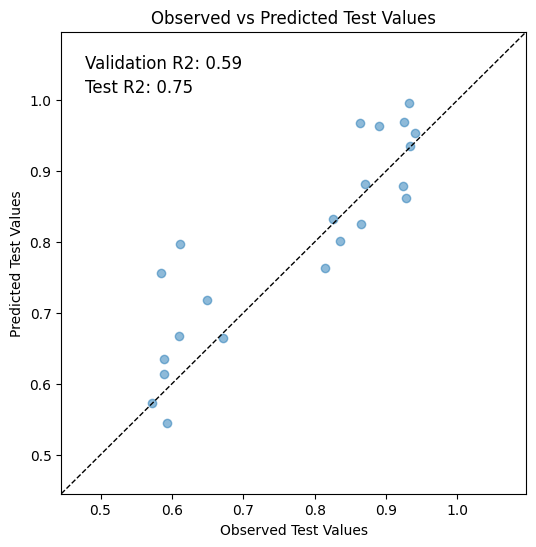

In [ ]:
min_val = min(min(y_pred), min(y_test)) - 0.1
max_val = max(max(y_pred), max(y_test)) + 0.1

plt.figure(figsize=(6, 6))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.scatter(y_test, y_pred, alpha=0.5)

plt.xlabel('Observed Test Values')
plt.ylabel('Predicted Test Values')
plt.title('Observed vs Predicted Test Values')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.text(
    0.05, 0.95,
    f'Validation R2: {ridge.best_score_:0.2f}',
    transform=plt.gca().transAxes, fontsize=12,
    verticalalignment='top'
)
plt.text(
    0.05, 0.90,
    f'Test R2: {r2:.2f}',
    transform=plt.gca().transAxes, fontsize=12,
    verticalalignment='top'
)

plt.show()

## Predicting crop yield across Togo, and through time


In [ ]:
features_gdf = pd.get_dummies(features_gdf, columns=['admin_2'], prefix='admin_2')
y_pred_full = np.maximum(ridge.predict(features_gdf[feature_cols + location_cols ]), 0)

features_gdf['predicted_yield'] = y_pred_full
features_gdf.head()

NameError: name 'features_gdf' is not defined

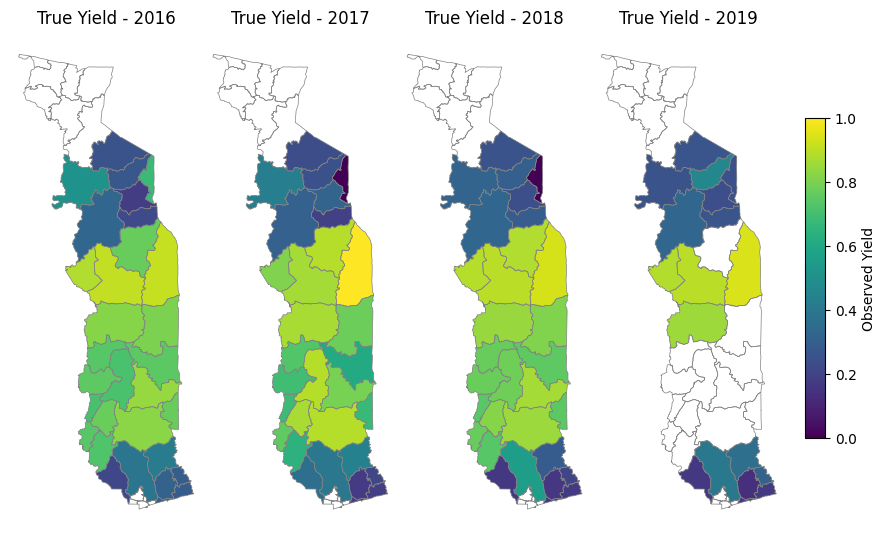

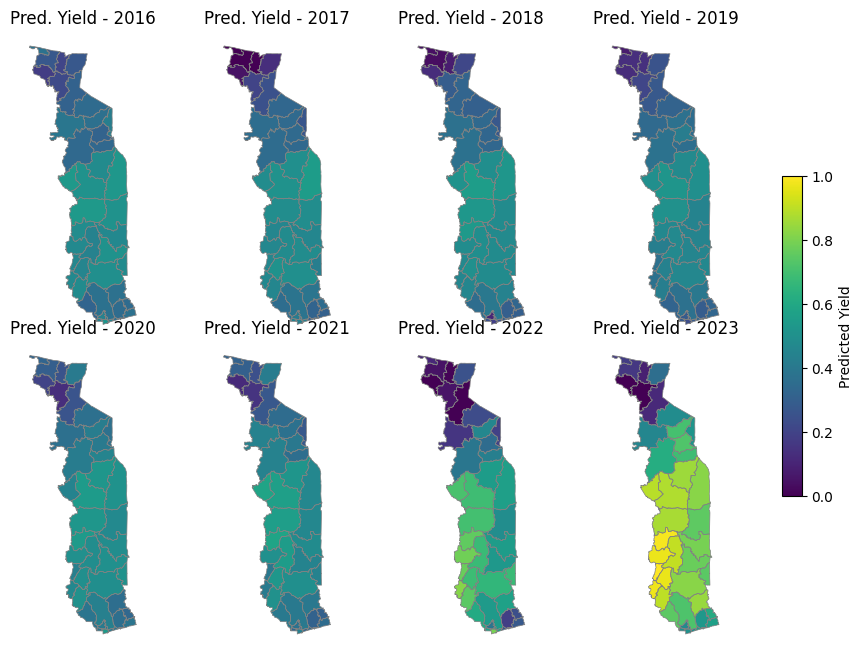

In [ ]:
years = sorted(crop_data_gdf['year'].unique())

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 4, figure=fig, wspace=0.01, hspace=0.01)

vmin = crop_data_gdf['log_yield'].min()
vmax = crop_data_gdf['log_yield'].max()

for i, year in enumerate(years):
    ax = fig.add_subplot(gs[i])
    TGO_boundaries.boundary.plot(ax=ax, color='grey', lw=0.5)
    im = crop_data_gdf[crop_data_gdf['year'] == year].plot(
        column='log_yield',
        ax=ax,
        legend=False,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f'True Yield - {year}')
    ax.set_axis_off()

cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
fig.colorbar(im.collections[0], cax=cax, label='Observed Yield')

plt.show()




tmp = features_gdf.copy()
# tmp = tmp.loc[tmp.year <= 2019]

years = sorted(tmp['year'].unique())

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 4, figure=fig, wspace=0.01, hspace=0.01)

vmin = tmp['predicted_yield'].min()
vmax = tmp['predicted_yield'].max()

for i, year in enumerate(years):
    ax = fig.add_subplot(gs[i])
    TGO_boundaries.boundary.plot(ax=ax, color='grey', lw=0.5)
    im = tmp[tmp['year'] == year].plot(
        column='predicted_yield',
        ax=ax,
        legend=False,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f'Pred. Yield - {year}')
    ax.set_axis_off()

cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
fig.colorbar(im.collections[0], cax=cax, label='Predicted Yield')

plt.show()

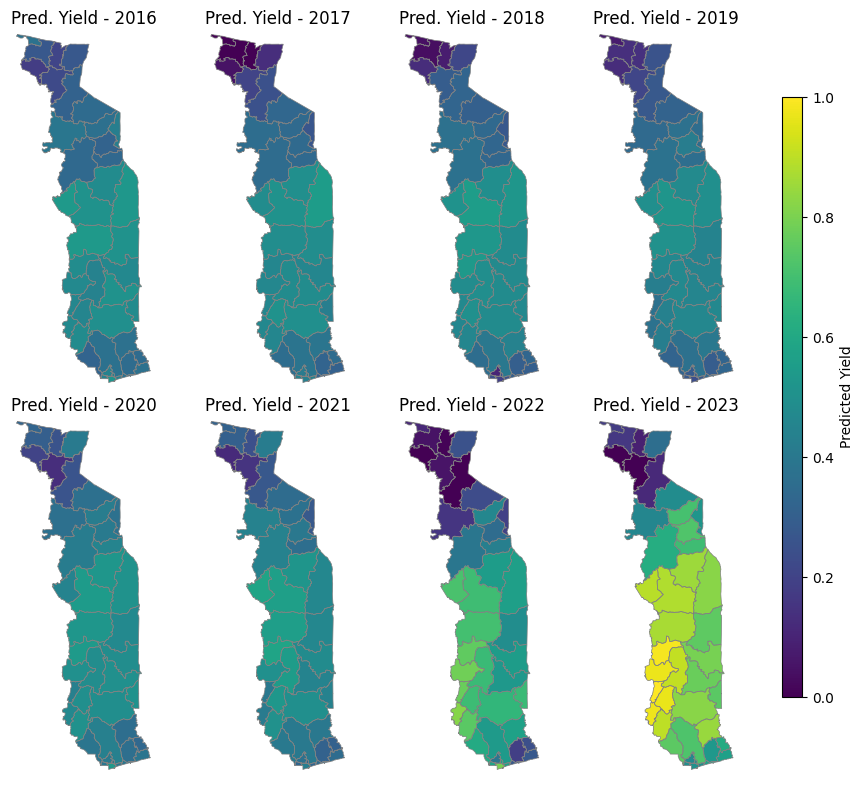

In [ ]:
years = sorted(features_gdf['year'].unique())

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 4, figure=fig, wspace=0.01, hspace=0.01)

vmin = features_gdf['predicted_yield'].min()
vmax = features_gdf['predicted_yield'].max()

for i, year in enumerate(years):
    ax = fig.add_subplot(gs[i])
    TGO_boundaries.boundary.plot(ax=ax, color='grey', lw=0.5)
    im = features_gdf[features_gdf['year'] == year].plot(
        column='predicted_yield',
        ax=ax,
        legend=False,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f'Pred. Yield - {year}', y = 0.96)
    ax.set_axis_off()

cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
fig.colorbar(im.collections[0], cax=cax, label='Predicted Yield')

plt.show()

https://www.aagwa.org/country-forecast-briefs